In [52]:
import pyddm
import numpy as np
import random
import pandas as pd
from riskyneuroarousal.utils.ddm_sample_generator import (get_ddm_model_2, 
                                                          get_model_samples)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
drift = 0.06981909179687501
c = -0.07236474609375
alpha = 1.399974609375
lambd= 1.1876859130859374
bound = 2.5499426269531247
theta = 0.6515035400390625
x0 = 0.1028212890625
nondectime = 0.3040329924795568

In [3]:
model = get_ddm_model_2(x0=x0, 
                        drift=drift, 
                        c = c, 
                        alpha = alpha,
                        lambd = lambd,
                        bound = bound,
                        theta = theta,
                        nondecision=nondectime,)

In [4]:
def get_trials(gains, losses, repetitions = 1):
    trials = []
    for g in gains:
        for l in losses:
            trials += [{"gain": g, "loss": l}] * repetitions
    
    random.shuffle(trials)
    return pd.DataFrame(trials)

In [5]:
gains = np.arange(5, 21, 1)
gains2 = np.arange(10, 41, 2)
losses = np.arange(5, 21, 1)
trials = get_trials(gains2, losses, repetitions=1)

In [6]:
trials["sub"] = 1
trials["condition"] = 'equalIndifference'

In [7]:
sim = get_model_samples(trials, model, samples_per_condition=50)

<Axes: xlabel='RT', ylabel='Count'>

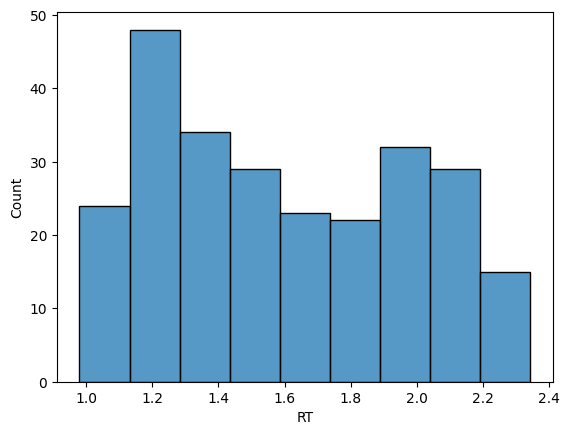

In [8]:
sns.histplot(data=sim, x="RT")

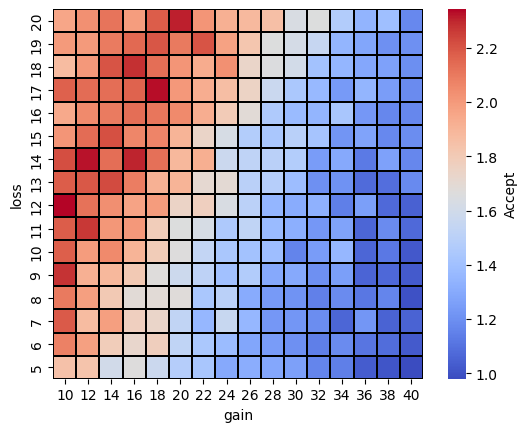

In [10]:
hmap_data = sim.groupby(['loss', 'gain'])['RT'].mean().unstack()
# Reverse the order of gain
hmap_data = hmap_data.iloc[::-1]
ax = sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Accept'}, square=True, linewidths=0.2, linecolor='black', cbar = True)

##### Comparison model DDM with SVs

In [110]:
x = pd.read_csv('ddm_parameters4.csv').query("sub != 56").reset_index(drop=True)

In [111]:
x["model"].unique()

array(['normal', 'theta', 'driftbias', 'startingpointnohistory',
       'startingpoint', 'driftbiasnohistory'], dtype=object)

In [96]:
len(x.query("model == 'driftbiasnohistorycontinuous'")['sub'].unique())

54

(350.0, 450.0)

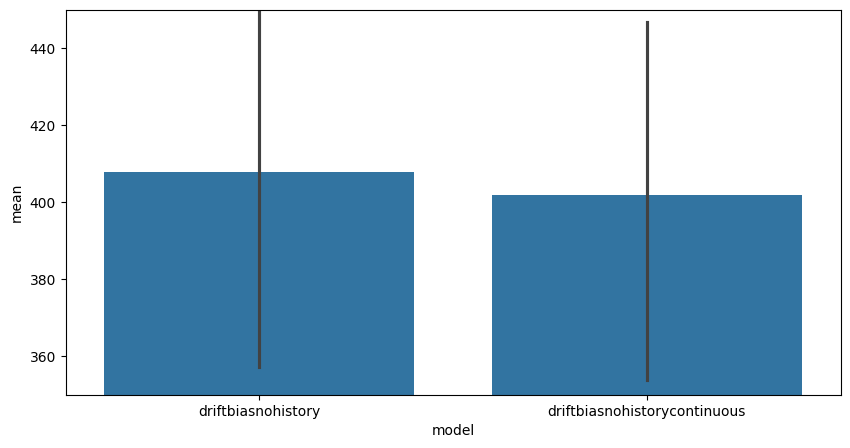

In [97]:
fig = plt.figure(figsize=(10, 5))
sns.barplot(x.query(f"param_name == 'BIC' "), x = "model", y = "mean")
plt.ylim(350, 450)

(350.0, 450.0)

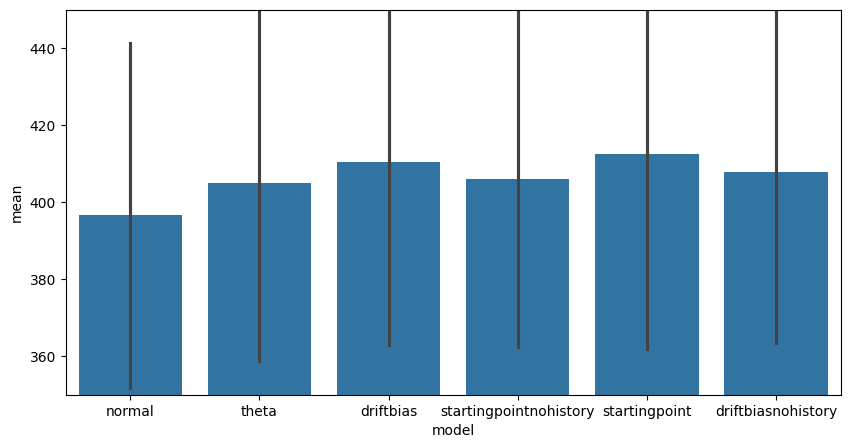

In [74]:
fig = plt.figure(figsize=(10, 5))
sns.barplot(x.query(f"param_name == 'BIC'"), x = "model", y = "mean")
plt.ylim(350, 450)

In [32]:
x["model"].unique()

array(['ddm.csv', 'startingpoint', 'driftbias', 'ddm2.csv'], dtype=object)

In [112]:
x1 = x.query("model == 'normal'").reset_index(drop=True)

<Axes: ylabel='mean'>

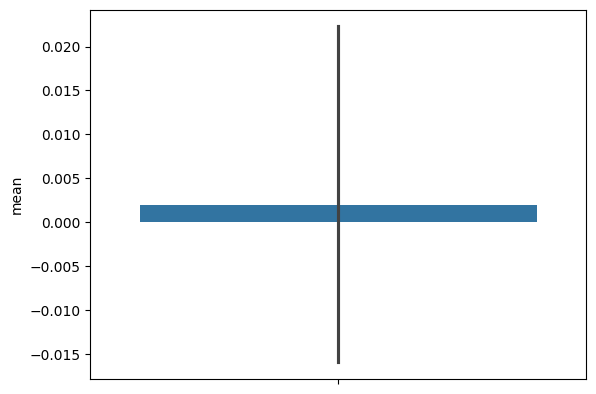

In [103]:
sns.barplot(x1.query("param_name == 'v_pupil_size'"), y = "mean")

In [113]:
x1.query("param_name== 'BIC'")['mean'].mean()

np.float64(396.6953745265663)

In [81]:
x1["param_name"].unique()

array(['a', 'z', 't', 'theta',
       'v_C(pupil_bin)[High]:dir_opposite_prev_response',
       'v_C(pupil_bin)[Low]:dir_opposite_prev_response',
       'v_C(pupil_bin)[Medium]:dir_opposite_prev_response',
       'v_decision_value_norm', 'BIC'], dtype=object)

In [82]:
x1['param_name'] = x1['param_name'].str.replace(
    r'^v_C\(pupil_bin\)\[(Low|Medium|High)\].*$',
    lambda m: m.group(1).lower(),
    regex=True
)

In [84]:
x2 = x1.query("param_name in ['low', 'medium', 'high']").reset_index(drop=True)
x2['condition'] = np.where(x2['sub'] % 2 == 0, 'equalRange', 'equalIndifference')

In [104]:
svs = pd.read_csv('behavioral_data_SVs.csv')
mean_accept = svs.groupby(['sub', 'condition'])[['accept']].mean().reset_index().rename(columns={'accept': 'mean_accept'})


In [105]:
conditions = [
    mean_accept['mean_accept'] < 0.4,
    mean_accept['mean_accept'] > 0.6,
    (mean_accept['mean_accept'] >= 0.4) & (mean_accept['mean_accept'] <= 0.60)
]
# Define corresponding choices
choices = ['risk_averse', 'risk_prefered', 'neutral']

# Create new column
mean_accept['risk_profile'] = np.select(conditions, choices, default='unknown')

In [107]:
x1 = x1.merge(mean_accept[['sub', 'risk_profile']], on=['sub'], how='left')

In [108]:
risk_profile_counts = x1['risk_profile'].value_counts()
risk_profile_counts

risk_profile
risk_prefered    184
neutral          176
risk_averse       72
Name: count, dtype: int64

<Axes: xlabel='risk_profile', ylabel='mean'>

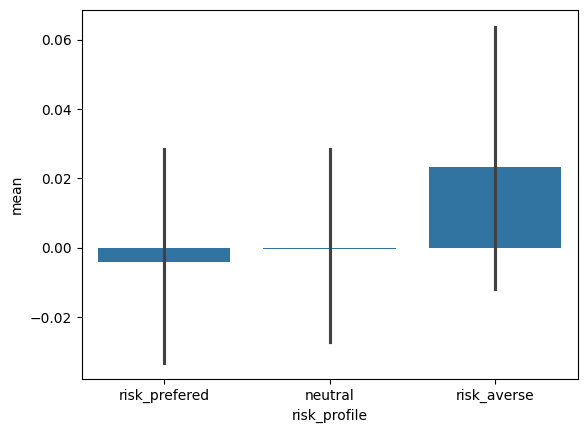

In [109]:
# # bar plot ordered low, medium, high
# x2['param_name'] = pd.Categorical(x2['param_name'], categories=['low', 'medium', 'high'], ordered=True)
# x2['mean'] = x2['mean'].astype(float)
sns.barplot(x1.query("param_name == 'v_pupil_size'"), x='risk_profile', y='mean')


In [ ]:
print("High", x1.query("param_name == 'v_C(pupil_bin)[High]:dir_opposite_prev_response'")['mean'].mean())
print("Medium", x1.query("param_name == 'v_C(pupil_bin)[Medium]:dir_opposite_prev_response'")['mean'].mean())
print("Low", x1.query("param_name == 'v_C(pupil_bin)[Low]:dir_opposite_prev_response'")['mean'].mean())

High -0.014017436905450362
Medium -0.03309673986007865
Low -0.04309025560079446


In [111]:
x1

,Unnamed: 0,param_name,mean,std,2.5q,25q,50q,75q,97.5q,mc err,sub,model,condition
0,20,a,1.923832,0.180861,1.616264,1.799909,1.907160,2.029659,2.317678,0.011134,109,ddm2.csv,equalIndifference
1,21,z,0.420678,0.014802,0.391327,0.410654,0.420839,0.430791,0.449368,0.000193,109,ddm2.csv,equalIndifference
2,22,t,0.576779,0.064813,0.431674,0.540185,0.582950,0.621875,0.682320,0.003781,109,ddm2.csv,equalIndifference
3,23,theta,0.451180,0.060128,0.332523,0.411509,0.450589,0.490558,0.567605,0.003438,109,ddm2.csv,equalIndifference
4,27,v_decision_value_norm,2.882347,0.111356,2.639448,2.814705,2.889470,2.958208,3.081734,0.003007,109,ddm2.csv,equalIndifference
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,1007,a,1.553737,0.132420,1.338795,1.463868,1.537427,1.625253,1.874692,0.006910,85,ddm2.csv,equalIndifference
266,1008,z,0.555666,0.018235,0.519868,0.543382,0.555957,0.568173,0.590869,0.000385,85,ddm2.csv,equalIndifference
267,1009,t,0.559806,0.041824,0.458668,0.536410,0.564899,0.588830,0.626268,0.002038,85,ddm2.csv,equalIndifference
268,1010,theta,0.400484,0.069617,0.278905,0.355116,0.394074,0.438387,0.561218,0.003313,85,ddm2.csv,equalIndifference


In [32]:
import matplotlib.pyplot as plt
from scipy.stats import false_discovery_control
import scipy.stats as stats

In [48]:
# Rename terms in column param_names that start with "v*" to "v"
x['param_name'] = x['param_name'].str.replace(r'^v_.*', 'v', regex=True)

In [51]:
# new column that is condition. equalIndifference if sub is odd, equalRange if sub is even
x['condition'] = np.where(x['sub'] % 2 == 0, 'equalRange', 'equalIndifference')

Text(0, 0.5, 'Mean Estimate')

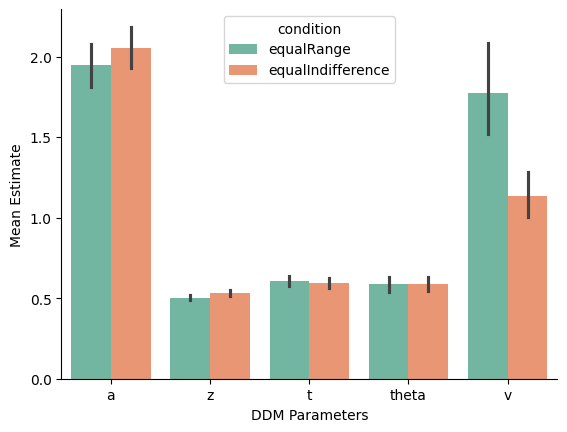

In [53]:
sns.barplot(data=x.query("param_name != 'BIC' & model_SV == 'CPT_ordinal'"), x='param_name', y='mean', hue = "condition", palette='Set2')
sns.despine()
plt.xlabel('DDM Parameters')
plt.ylabel('Mean Estimate')

In [38]:
p_values = []
t_stats = []
names = []
for i in range(4):
    for j in range(4):
        if i > j:
            model1 = x["model_SV"].unique()[i]
            model2 = x["model_SV"].unique()[j]
            data1 = x.query(f"param_name == 'BIC' & model_SV == '{model1}'").sort_values(by='sub')["mean"]
            data2 = x.query(f"param_name == 'BIC' & model_SV == '{model2}'").sort_values(by='sub')["mean"]
            t_stat, p_val = stats.ttest_rel(data1, data2)
            p_values.append(p_val)
            t_stats.append(t_stat)
            names.append(f"{model1} vs {model2}")

p_values = false_discovery_control(p_values, method = "by")
for i, name in enumerate(names):
    if p_values[i] < 0.05:
        print(f"Significant difference between {name} with p-value: {p_values[i]} and t-stat: {t_stats[i]}")

Significant difference between CPT_ordinal vs EV_ordinal with p-value: 0.0003157074876477172 and t-stat: -4.268637898917416
Significant difference between CPT_ordinal vs EV_binary with p-value: 0.0003157074876477172 and t-stat: -4.330604213045288


(375.0, 450.0)

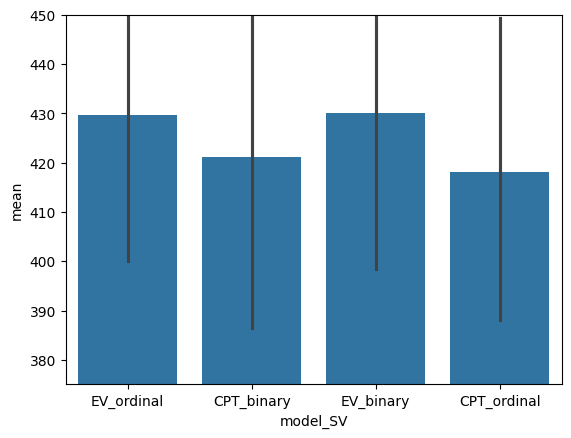

In [ ]:
sns.barplot(data=x.query("param_name == 'BIC'"), x = 'model_SV', y = 'mean')
plt.ylim(375, 450)